In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import cm
import glob
import os
import random
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px
import tensorflow as tf
import keras
from keras.layers import Input, Dense, Flatten, Reshape, Convolution1D, Conv1D, \
    MaxPooling1D, UpSampling1D,Cropping1D, LSTM, RepeatVector,Activation, TimeDistributed
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Process description
Below is the scheme of the pilot plant (adapted from Process summary, the ChemEng Discovery space, Imperial College London). There are six sampling points between stages, and all the sampling points are fed to the same gas analyzer. However, the gas analyzer can only process the sampling stream one at a time, i.e., at any given time, there is only one position that the gaseous $CO_2$ concentration is known.
<img src="images/pilot_plant.jpg" width="500">

In [2]:
# Records in the spreadsheet are are already labelled
data_path_list = glob.glob('./data/withLabel/1*.xlsx')
list_of_origin_df=[]
for i in range(len(data_path_list)):
    xls = pd.ExcelFile(data_path_list[i])
    data_df = pd.read_excel(xls, sheet_name=0, index_col=0, header = [0,1])
    data_df.columns = data_df.columns.map(''.join)
    data_df=data_df.rename_axis('time').reset_index()
    tmp_name=list(data_df.columns)
    tmp_name[-1]='label'
    data_df.columns=tmp_name
    list_of_origin_df.append(data_df)

Labelled process record:

In [3]:
list_of_origin_df[0].head()

,time,AT100(pH),AT300(pH),AT400(CO2 %),FT100(kg/hr),FT101(kg/hr),FT102(kg/hr),FT103(kg/hr),FT104(kg/hr),FT105(L/min),...,TT400(0C),TT401(0C),TT402(0C),TT403(0C),TT404(0C),TT410(0C),TT411(0C),TT412(0C),TT413(0C),label
0,2014-01-20 17:23:02,10.468116,10.856668,0.109407,49.641636,0,114.306496,253.188339,244.473846,0.076785,...,117.106621,116.955292,116.753510,22.537117,104.836342,22.658978,34.482868,36.524200,33.270100,1
1,2014-01-20 17:23:46,10.429050,10.856927,0.098878,49.669559,0,73.167267,253.357178,244.543427,0.076773,...,116.413254,116.233284,116.142960,22.537117,105.931946,22.678768,33.612118,35.468010,32.640736,1
2,2014-01-20 17:24:29,10.380840,10.868021,0.001587,49.750290,0,30.941877,254.384949,244.684982,0.076896,...,115.733566,115.700668,115.546623,22.537117,106.712189,22.689386,32.948505,34.523560,32.053650,1
3,2014-01-20 17:25:12,10.319781,10.888022,0.000000,49.734818,0,65.672806,254.687668,244.545029,0.076057,...,115.841347,115.708611,115.522621,22.537117,107.563896,22.699842,32.655727,33.851078,31.548174,2
4,2014-01-20 17:25:55,10.248368,10.903030,0.000364,49.566025,0,15.200113,254.401810,244.331406,0.076959,...,114.879135,114.479225,114.496765,22.537117,107.848602,22.714924,32.635029,33.495365,31.267054,2


The measurements consist of 53 temperature transmitters, 12 pressure transmitters, 19 flow transmitters, 4 level transmitters, 2 pH analyzers and the previously discussed gas concentration analyzer. The measurements cover the pilot plant process including the elements shown in previous figure as well as the various gas handling and storage systems and the auxiliary processes. Key measurements of the absorber column include (with descriptions on the P&ID):

* FT103: Flow transmitter, $CO_2$ lean amine solution, valid range 120-12000 kg/hr.
* FT104: Flow transmitter, $CO_2$ lean amine solution, valid range 100-1600 kg/hr, connects in serial with FT103.
* TT210: Temperature transmitter, temperature of $CO_2$ lean amine solution, K.
* TT211: Temperature transmitter, temperature of $CO_2$ lean amine solution, K, connects in serial with TT210.
* FT303: Flow transmitter, $N_2$ absorber inlet (volumetric) flowrate, valid range 38.7-575 kg/hr.
* FT304: Flow transmitter, $N_2$ absorber inlet flowrate, valid range 4.4-438 kg/hr, connects in serial with FT303.
* PT403: Pressure transmitter, $N_2$ absorber inlet pressure, valid range -1-4 barG.
* TT304: Temperature transmitter, $N_2$ absorber inlet temperature, K.
* FT301: Flow transmitter, $CO_2$ absorber inlet (volumetric) flowrate, valid range 7.14-71.4 kg/hr.
* FT302: Flow transmitter, $CO_2$ absorber inlet flowrate, valid range 1.56-156 kg/hr, connects in serial with FT301.
* PT402: Pressure transmitter, $CO_2$ absorber inlet pressure, valid range -1-4 barG.
* TT104: Temperature transmitter, temperature of $N_2, CO_2$ mixture at absorber inlet, K.
* PT111: Pressure transmitter, bottom of the absorber, valid range -1-4 barG.
* PT403: Pressure transmitter, top of the absorber, valid range -1-4 barG.

Note the pressure transmitter of $N_2$ and of the top of the absorber is the same. The lean gas ($N_2$) is recycled from top of the absorber and mix with the $CO_2$, and forms the $CO_2$-rich feed gas.

# Kinetic (dynamic) modeling
Instead of implementing complicated kinetic correlations, we fit a pseudo reaction to approximate the absorption process
$CO_{2,(g)} + MEA_{(l)} \underset{reaction_2}{\stackrel{reaction_1}{\rightleftharpoons}} \left[ CO_2-MEA\right]_{binded_{(l)}}$

$R_1 = k_1 \cdot \exp^{\frac{-E_{A1}}{8.314\left(\alpha_1\cdot T +\beta_1\right)}}$,
$R_2 = k_2 \cdot \exp^{\frac{-E_{A2}}{8.314\left(\alpha_2\cdot T+\beta_2\right)}}$,

The vector of parameters are combined as x0 = [$k_1, \alpha_1, \beta_1, k_2, \alpha_2, \beta_2$]

kinetic_model contains the Simulink model of the absorber. Please note that the parameters in the Simulink model are outdated and need to be run by Matlab script to update these parameters.
The result_generation ran the kinetic_model with the fitted parameter: x0=[500.6,1,1005.5,4380,1,1263]. The results are tagged as "time stamp.csv". A schematic of the Simulink model is shown below:

<img src="images/kinetic_scheme.png" width="1000">

# data-driven modeling

In [4]:
def reset_random_seeds():
    os.environ['PYTHONHASHSEED']=str(0)
    tf.random.set_seed(0)
    np.random.seed(0)
    random.seed(0)

def avgOutPoint1(df):
    #Change point 1 readings to Avg. of Point 2.
    label_list=list(df['label'])
    conc_list = list(df['AT400(CO2 %)'])
    p=0
    num=0
    i=0
    sampling2_avgcon = list()
    while i<len(label_list):
        if label_list[i]==2:
            p=p+conc_list[i]
            num=num+1
            i=i+1
        else:
            if p ==0 and num==0:
                i=i+1
                pass
            else:
                sampling2_avgcon.append(p/num)
                i =i+1
                num=0
                p=0

    i=0
    k=-1
    while i<(len(label_list)-1):
        if label_list[i]==1:
            conc_list[i]=sampling2_avgcon[k]
            i=i+1
        else:
            if label_list[i+1]==1 :
                k=k+1
                i=i+1
            else:
                i=i+1
    #set new AT400
    df['AT400(CO2 %)']=pd.Series(data=conc_list,index=df.index)
    return df

def columnSeparator(df):
    # linear interpolation to fill missing values
    for i in range(1,7): # 6 sampling points
        new_con =list()
        j = 0
        while j<df.shape[0]:
            if df.iloc[j]['label']==i:
                new_con.append( df.iloc[j]['AT400(CO2 %)'])
                j = j+1
            else:
                new_con.append(np.nan)
                j = j+1
        df[str(i)+"_sampling"]=pd.Series(data=new_con,index=df.index)
        df[str(i)+"_sampling"]=df[str(i)+"_sampling"].interpolate(method="linear")
    # Notice the df will contain NaN for the first few rows for each sampling point column
    return df

def getU(ens,reduced_dimension):
    # assuming ens has shape of [sampe_size, sample_ravel()]
    u, s, vh = np.linalg.svd(ens.T, full_matrices=False)
    truncation_parameter = reduced_dimension
    print('Truncation parameter: ',truncation_parameter)
    u1=u[:,:truncation_parameter]
    s1=s[:truncation_parameter]
    vh1=vh[:truncation_parameter,:]
    return u1

def dfPOD(train_df_list, test_df_list, _train_feature_list, _label_list, reduced_dimension):
    print('Train df(1st one) shape before POD: ', train_df_list[0].shape)
    print('Test df(1st one) shape before POD: ', test_df_list[0].shape)
    
    label_list=_label_list.copy()
    train_feature_list=_train_feature_list.copy()
    #train_feature_list.remove('AT400(CO2 %)')
    #label_list.append('AT400(CO2 %)')
    
    for i in range(len(train_df_list)):
        if (i==0):
            train_full_values=train_df_list[i][train_feature_list].values
            train_label_values=train_df_list[i][label_list].values
        else:
            train_full_values=np.concatenate((train_full_values, train_df_list[i][train_feature_list].values), axis=0)
            train_label_values=np.concatenate((train_label_values, train_df_list[i][label_list].values), axis=0)
    for i in range(len(test_df_list)):
        if (i==0):
            test_full_values=test_df_list[i][train_feature_list].values
            test_label_values=test_df_list[i][label_list].values
        else:
            test_full_values=np.concatenate((test_full_values, test_df_list[i][train_feature_list].values), axis=0)
            test_label_values=np.concatenate((test_label_values, test_df_list[i][label_list].values), axis=0)
    
    n_set = train_full_values.shape[0]
    train_index = list(set(range(0,n_set,1))- set(range(0,n_set,5)))
    test_index = list(set(range(0,n_set,5)))
    
    x_train = train_full_values[train_index]; x_val = train_full_values[test_index]
    x_test = test_full_values; 

    u1 = getU(x_train, reduced_dimension)

    x_train_encoded = u1.T @ x_train.T # shape [truncation_parameter, sample size]
    x_val_encoded = u1.T @ x_val.T
    x_test_encoded = u1.T @ x_test.T

    x_train_decoded = (u1 @ x_train_encoded).T # shape [sampe_size, sample_ravel()]
    x_val_decoded = (u1 @ x_val_encoded).T
    x_test_decoded = (u1 @ x_test_encoded).T
    
    print("Train: ", mean_squared_error(x_train,x_train_decoded));
    print("Val: ", mean_squared_error(x_val,x_val_decoded));
    print("Test: ", mean_squared_error(x_test,x_test_decoded));
    
    encoded_train= (u1.T @ train_full_values.T).T#.reshape(train_full_values.shape[0],train_full_values.shape[2])
    encoded_test= (u1.T @ test_full_values.T).T#.reshape(test_full_values.shape[0],test_full_values.shape[2])
    encoded_name_list=['encoded_{}'.format(i) for i in range(1,encoded_train.shape[1]+1)]
    upper_index=0
    bottom_index=0
    for i in range(len(train_df_list)):
        upper_index=bottom_index
        bottom_index=upper_index+train_df_list[i].shape[0]
        train_df_list[i]=pd.DataFrame(np.concatenate((encoded_train[upper_index:bottom_index,:],train_df_list[i][label_list].values),axis=1),
                                     columns=encoded_name_list+label_list)
    upper_index=0
    bottom_index=0
    for i in range(len(test_df_list)):
        upper_index=bottom_index
        bottom_index=upper_index+test_df_list[i].shape[0]
        test_df_list[i]=pd.DataFrame(np.concatenate((encoded_test[upper_index:bottom_index,:],test_df_list[i][label_list].values),axis=1),
                                     columns=encoded_name_list+label_list)
    print('Train df(1st one) shape after AE: ', train_df_list[0].shape)
    print('Test df(1st one) shape after AE: ', test_df_list[0].shape)
    return train_df_list,test_df_list

def dfAE(train_df_list, test_df_list, _train_feature_list, _label_list, reduced_dimension):
    print('Train df(1st one) shape before AE: ', train_df_list[0].shape)
    print('Test df(1st one) shape before AE: ', test_df_list[0].shape)
    
    label_list=_label_list.copy()
    train_feature_list=_train_feature_list.copy()
    #train_feature_list.remove('AT400(CO2 %)')
    #label_list.append('AT400(CO2 %)')
    
    for i in range(len(train_df_list)):
        if (i==0):
            train_full_values=train_df_list[i][train_feature_list].values
            train_label_values=train_df_list[i][label_list].values
        else:
            train_full_values=np.concatenate((train_full_values, train_df_list[i][train_feature_list].values), axis=0)
            train_label_values=np.concatenate((train_label_values, train_df_list[i][label_list].values), axis=0)
    for i in range(len(test_df_list)):
        if (i==0):
            test_full_values=test_df_list[i][train_feature_list].values
            test_label_values=test_df_list[i][label_list].values
        else:
            test_full_values=np.concatenate((test_full_values, test_df_list[i][train_feature_list].values), axis=0)
            test_label_values=np.concatenate((test_label_values, test_df_list[i][label_list].values), axis=0)
    
    n_set = train_full_values.shape[0]
    train_index = list(set(range(0,n_set,1))- set(range(0,n_set,5)))
    test_index = list(set(range(0,n_set,5)))
    
    x_train = train_full_values[train_index]; x_val = train_full_values[test_index]
    x_test = test_full_values; 
    print('LSTM x_train shape: ', x_train.shape[0])

    noise_factor = 0.1
    scale_arr = np.var(x_train,axis=0)
    x_train = x_train + noise_factor * np.random.normal(loc=0.0, scale=scale_arr, size=x_train.shape) 
    x_test = x_test + noise_factor * np.random.normal(loc=0.0, scale=scale_arr, size=x_test.shape) 
    x_train = np.clip(x_train, 0., 1.)
    x_test = np.clip(x_test, 0., 1.)
    # AE shape default design
    input_img = Input(shape=(x_train.shape[1]))
    x = Dense(64,activation='relu',kernel_initializer=ReLu)(input_img)
    encoded = Dense(reduced_dimension,activation='relu',kernel_initializer=ReLu)(x)


    encoder = Model(input_img, encoded)
    encoder.summary()

    decoder_input = Input(shape=(reduced_dimension))

    x = Dense(64)(decoder_input)
    decoded = Dense(x_train.shape[1], activation='sigmoid')(x)

    decoder = Model(decoder_input, decoded)
    decoder.summary()

    encoder=Model(inputs=input_img, outputs=encoded, name = 'encoder')
    decoder=Model(inputs=decoder_input, outputs=decoded, name = 'decoder')
    autoencoder_outputs = decoder(encoder(input_img))
    autoencoder= Model(input_img, autoencoder_outputs, name='autoencoder')
    autoencoder.summary()
    #Optimizers 
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    autoencoder.compile(optimizer=opt, loss="mse")

    # Set callback functions to early stop training and save the best model so far
    early_stopping_monitor = [EarlyStopping(monitor='val_loss', patience=30, verbose=0,restore_best_weights=True)]

    history = autoencoder.fit(x_train, x_train, epochs=500, batch_size=40,shuffle=True, 
                              validation_data=(x_val, x_val), callbacks=early_stopping_monitor)
    #loss: 0.0217 - val_loss: 0.0230 before adding dense
    autoencoder.save(os.path.join('DAE'))
    autoencoder=keras.models.load_model(os.path.join('DAE'))

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    print('Train: ',mean_squared_error(x_train,autoencoder.predict(x_train)))
    print('Val: ',mean_squared_error(x_val,autoencoder.predict(x_val)))
    print('Test: ',mean_squared_error(x_test,autoencoder.predict(x_test)))
    
    encoder = autoencoder.get_layer("encoder")
    encoded_train=encoder.predict(train_full_values)#.reshape(train_full_values.shape[0],train_full_values.shape[2])
    encoded_test=encoder.predict(test_full_values)#.reshape(test_full_values.shape[0],test_full_values.shape[2])
    encoded_name_list=['encoded_{}'.format(i) for i in range(1,encoded_train.shape[1]+1)]
    upper_index=0
    bottom_index=0
    for i in range(len(train_df_list)):
        upper_index=bottom_index
        bottom_index=upper_index+train_df_list[i].shape[0]
        train_df_list[i]=pd.DataFrame(np.concatenate((encoded_train[upper_index:bottom_index,:],train_df_list[i][label_list].values),axis=1),
                                     columns=encoded_name_list+label_list)
    upper_index=0
    bottom_index=0
    for i in range(len(test_df_list)):
        upper_index=bottom_index
        bottom_index=upper_index+test_df_list[i].shape[0]
        test_df_list[i]=pd.DataFrame(np.concatenate((encoded_test[upper_index:bottom_index,:],test_df_list[i][label_list].values),axis=1),
                                     columns=encoded_name_list+label_list)
    print('Train df(1st one) shape after AE: ', train_df_list[0].shape)
    print('Test df(1st one) shape after AE: ', test_df_list[0].shape)
    return train_df_list,test_df_list

def getSampleSet(df_list, callback, train_feature_list, label_list):
    conc_label_list=[]
    for i in range(len(df_list)):
        # The 1st element in label list is label
        nset = df_list[i].shape[0]-callback
        print("Number of set: ", nset)
        conc_input=np.zeros((df_list[i].shape[0],6)) # Only the true reading is non-zero
        conc_set = df_list[i][label_list[1:]].values # Excl. 1st column, label column
        conc_set[np.isnan(conc_set)]=0
        parameter_set = df_list[i][train_feature_list].values
        for k in range(conc_input.shape[0]): # Only the true reading is non-zero, default for onehot
            conc_input[k][int(df_list[i]['label'][k])-1]=1        
        conc_input[np.isnan(conc_input)]=0
        parameter_set=np.hstack((parameter_set,conc_input))
        sample_set=np.zeros((nset,callback+1,parameter_set.shape[1]))
        label_set=np.zeros((nset,1,conc_set.shape[1]))
        for j in range(nset):
            sample_set[j]=parameter_set[0+j:callback+j+1]
            label_set[j]=conc_set[callback+j]
        
        if (i==0):
            total_sample_set=np.zeros((0,callback+1,parameter_set.shape[1]))
            total_label_set=np.zeros((0,1,conc_set.shape[1]))
        conc_label_list.append(label_set)
        total_sample_set = np.vstack([total_sample_set,sample_set])
        total_label_set = np.vstack([total_label_set,label_set])
        
    return total_sample_set, total_label_set, conc_label_list
        

def getDataSet(path_list,df_list, callback, test_df_index_list, mode, reduced_dimension):
    # Pre-processing: avg. out Conc @ sampling point 1
    print('Timestamp in selected Test df list: ')
    for i in range(len(test_df_index_list)):
        print(os.path.basename(path_list[test_df_index_list[i]]))
    for i in range(len(df_list)):
        df_list[i]=df_list[i].set_index('time')
        #df_list[i]=df_list[i].drop(columns=["time"])
        df_list[i] = avgOutPoint1(df_list[i])
        if (i==0):
            origin_feature_num = df_list[i].shape[1]
            print("Origin input DF feature num(excl time, incl. label): ", origin_feature_num)

    # Separate df_list into Train & Test df lists
    test_df_list = list(pd.Series(df_list)[test_df_index_list]) # The 140207_1 is selected as the testset
    train_df_list = list(pd.Series(df_list)[list(set(range(0,len(df_list),1))-set(test_df_index_list))])

    #Min-max scaler, calculated from train_df_list
    for i in range(len(train_df_list)):
        if (i==0):
            tmp_full_values=train_df_list[i].values
            tmp_conc_values=train_df_list[i]['AT400(CO2 %)'].values
        else:
            tmp_full_values=np.concatenate((tmp_full_values, train_df_list[i].values), axis=0)
            tmp_conc_values=np.concatenate((tmp_conc_values, train_df_list[i]['AT400(CO2 %)'].values), axis=0)
    tmp_full_values = tmp_full_values[:,:-1] # excl. label column as well
    general_scaler = MinMaxScaler()
    conc_scaler = MinMaxScaler()
    general_scaler.fit(tmp_full_values)
    conc_scaler.fit(tmp_conc_values.reshape(-1,1))

    print('Conc scaler max: ',conc_scaler.data_max_)

    # Process into + ['label', '1_sampling', '2_sampling', '3_sampling', '4_sampling', '5_sampling', '6_sampling']
    for i in range(len(df_list)):
        df_list[i].iloc[:,:-1] = general_scaler.transform(df_list[i].iloc[:,:-1].values)
        df_list[i] = columnSeparator(df_list[i])
        df_list[i]=df_list[i].fillna(0)

    nan_num = 0
    for df in df_list:
        #print(df.dtypes)
        avail_index = (df['6_sampling']>=0).argmax()
        if (nan_num < avail_index):
            nan_num = avail_index
    print("Minimum call back is: ", nan_num+1)
    if (nan_num+1<callback):
        print('The smallest feasible callback is: ', nan_num+1)

    # Separate df_list into Train & Test df lists
    test_df_list = list(pd.Series(df_list)[test_df_index_list]) # The 140207_1 is selected as the testset
    train_df_list = list(pd.Series(df_list)[list(set(range(0,len(df_list),1))-set(test_df_index_list))])

    print("train list: ", len(train_df_list))
    label_list=['label', '1_sampling', '2_sampling', '3_sampling', '4_sampling', '5_sampling', '6_sampling']
    train_feature_list = list(np.sort(list(set(df_list[0].columns)-set(label_list))))
    if (mode == 'PCA'):
        if (reduced_dimension == 16):
            train_feature_list = ['TT113(0C)','TT300(0C)','TT302(0C)','TT202(0C)','TT304(0C)',"TT400(0C)",
                                  "TT410(0C)",'PT103(barg)','PT402(barg)','PT403(barg)','PT102(barg)' ,'AT300(pH)',
                                  'FT302(kg/hr)', 'FT303m3/hr','FT304(kg/hr)','FT103(kg/hr)']
        else:
            train_feature_list = ['TT302(0C)','TT300(0C)','TT401(0C)','TT303(0C)','TT400(0C)','TT113(0C)',
                                  'TT301(0C)','TT202(0C)','TT412(0C)','TT309(0C)','TT110a(0C)','TT410(0C)',
                                  'TT112(0C)','PT103(barg)','PT402(barg)','PT401(barg)','TT404(0C)', 'TT214(0C)',
                                  'FT304(kg/hr)','AT100(pH)','FT303m3/hr','AT300(pH)','FT105(L/min)','FT103(kg/hr)',
                                  'PT403(barg)','TT304(0C)','FT301m3/hr','TT107(0C)', 'PT110(barg)','PT111(barg)',
                                  'TT210(0C)','TT211(0C)']
    if (mode == 'DAE'):
        train_df_list, test_df_list=dfAE(train_df_list, test_df_list, train_feature_list, label_list, reduced_dimension)
        train_feature_list = np.sort(list(set(train_df_list[0].columns)-set(label_list)))
    if (mode == 'POD'):
        train_df_list, test_df_list=dfPOD(train_df_list, test_df_list, train_feature_list, label_list, reduced_dimension)
        train_feature_list = np.sort(list(set(train_df_list[0].columns)-set(label_list)))
    train_sample_set, train_label_set,_ = getSampleSet(train_df_list, callback, train_feature_list, label_list)
    test_sample_set, test_label_set,test_conc_list = getSampleSet(test_df_list, callback, train_feature_list, label_list)

    
    return train_sample_set, train_label_set, test_sample_set, test_label_set, conc_scaler, train_df_list, test_df_list, test_conc_list

def GCfunc(i, j, corr_length):
    r = abs(i-j)/corr_length
    if (r>=0 and r<1):
        return (1-pow(r,2)*5/3+pow(r,3)*5/8+pow(r,4)*0.5-pow(r,5)*0.25)
    if (r>=1 and r<2):
        return (4-5*r+pow(r,2)*5/3+pow(r,3)*5/8-pow(r,4)*0.5+pow(r,5)/12-2/3/r)
    else:
        return 0

def covLoc(B, corr_length):
    ls_size=B.shape[0]
    for i in range(ls_size):
        for j in range(ls_size):
            B[i][j] = B[i][j]*GCfunc(i,j,corr_length)
    return B

def trainSequenceLSTM(state, train_sample_set, train_label_set, test_sample_set, test_label_set):
    n_sequence = train_sample_set.shape[1]
    n_feature = train_sample_set.shape[2]
    n_set = train_sample_set.shape[0]
    print('train_sample_set shape: ', train_sample_set.shape)
    
    train_index = list(set(range(0,n_set,1))- set(range(0,n_set,5)))
    test_index = list(set(range(0,n_set,5)))
    x_train = train_sample_set[train_index]; x_val = train_sample_set[test_index]
    y_train = train_label_set[train_index]; y_val = train_label_set[test_index]
    x_test = test_sample_set; y_test = test_label_set
    print('Train len: %d, Val len: %d' %(x_train.shape[0], x_val.shape[0]))
    print('x_train shape: '+str(x_train.shape)+ ', y_train shape:' + str(y_train.shape))

    
    if (state == 'train'):
        model = Sequential()
        model.add(LSTM(100,input_shape=(n_sequence,n_feature), return_sequences=True))
        model.add(keras.layers.Dropout(0.1))
        model.add(Dense(100))
        model.add(keras.layers.Dropout(0.1))
        model.add(Dense(100))
        model.add(keras.layers.Dropout(0.1))
        model.add(Dense(6, activation='sigmoid'))
        
        #Optimizers 
        #opt = tf.keras.optimizers.Adam(learning_rate=0.0003)
        opt = tf.keras.optimizers.Adam(learning_rate=0.00001)

        #model.compile(optimizer=opt, loss=my_loss_fn)
        model.compile(optimizer=opt, loss='mse')
        model.summary()
        # Set callback functions to early stop training and save the best model so far
        early_stopping_monitor = [EarlyStopping(monitor='val_loss', patience=70, verbose=0,restore_best_weights=True)]
        
        # fit model
        train_log = model.fit(x_train, y_train, batch_size=40, epochs=500, shuffle=True, 
                               validation_data=(x_val, y_val), callbacks=early_stopping_monitor)
        LSTM_model = model
        #Note the label
        model.save('LSTM_MSE.h5')

        plt.plot(train_log.history['loss'])
        plt.plot(train_log.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()
    else:
        model = keras.models.load_model('LSTM_MSE.h5')
    
    # Evaluate the model on the test data using `evaluate`
    print("Evaluate on test data")
    #results = model.evaluate(x_test, y_test, batch_size=36)
    predict_set=model.predict(x_test)
    results = mean_squared_error(conc_scaler.inverse_transform(np.mean(predict_set,axis=1)),conc_scaler.inverse_transform(y_test.reshape(y_test.shape[0],6)))
    print("MSE:", results)
    
    val_output_set = model.predict(x_val)
    
    print("Evaluate on validation")
    results = mean_squared_error(conc_scaler.inverse_transform(np.mean(val_output_set,axis=1)),conc_scaler.inverse_transform(y_val.reshape(y_val.shape[0],6)))
    print("MSE:", results)
    
    R=np.cov((conc_scaler.inverse_transform(np.mean(val_output_set,axis=1))- \
              conc_scaler.inverse_transform(y_val.reshape(y_val.shape[0],6))).T)
    R=covLoc(R,2)
    np.save('R.npy',R)

data/WithLabel\140120_1.xlsx
data/WithLabel\140206_1.xlsx
data/WithLabel\140207_1.xlsx
data/WithLabel\140207_2.xlsx
data/WithLabel\140214_1.xlsx
data/WithLabel\140214_2.xlsx
data/WithLabel\140227_1.xlsx
data/WithLabel\140313_1.xlsx
Timestamp in selected Test df list: 
140206_1.xlsx
Origin input DF feature num(excl time, incl. label):  91
Conc scaler max:  [12.03671837]
Minimum call back is:  1
The smallest feasible callback is:  1
train list:  7
Train df(1st one) shape before AE:  (117, 97)
Test df(1st one) shape before AE:  (50, 97)
LSTM x_train shape:  678
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 90)]              0         
_________________________________________________________________
dense (Dense)                (None, 64)                5824      
_________________________________________________________________
dense_1 (Dense)         

Epoch 55/500
17/17 [==============================] - 0s 4ms/step - loss: 0.0040 - val_loss: 0.0041
Epoch 56/500
17/17 [==============================] - 0s 4ms/step - loss: 0.0040 - val_loss: 0.0041
Epoch 57/500
17/17 [==============================] - 0s 4ms/step - loss: 0.0040 - val_loss: 0.0041
Epoch 58/500
17/17 [==============================] - 0s 4ms/step - loss: 0.0039 - val_loss: 0.0040
Epoch 59/500
17/17 [==============================] - 0s 4ms/step - loss: 0.0039 - val_loss: 0.0040
Epoch 60/500
17/17 [==============================] - 0s 4ms/step - loss: 0.0039 - val_loss: 0.0039
Epoch 61/500
17/17 [==============================] - 0s 4ms/step - loss: 0.0038 - val_loss: 0.0039
Epoch 62/500
17/17 [==============================] - 0s 4ms/step - loss: 0.0038 - val_loss: 0.0039
Epoch 63/500
17/17 [==============================] - 0s 4ms/step - loss: 0.0038 - val_loss: 0.0039
Epoch 64/500
17/17 [==============================] - 0s 4ms/step - loss: 0.0038 - val_loss: 0.0038


17/17 [==============================] - 0s 4ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 137/500
17/17 [==============================] - 0s 4ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 138/500
17/17 [==============================] - 0s 5ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 139/500
17/17 [==============================] - 0s 5ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 140/500
17/17 [==============================] - 0s 5ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 141/500
17/17 [==============================] - 0s 5ms/step - loss: 0.0030 - val_loss: 0.0032
Epoch 142/500
17/17 [==============================] - 0s 5ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 143/500
17/17 [==============================] - 0s 5ms/step - loss: 0.0030 - val_loss: 0.0032
Epoch 144/500
17/17 [==============================] - 0s 5ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 145/500
17/17 [==============================] - 0s 4ms/step - loss: 0.0031 - val_loss: 0.0032
Epoc

17/17 [==============================] - 0s 5ms/step - loss: 0.0028 - val_loss: 0.0030
Epoch 218/500
17/17 [==============================] - 0s 5ms/step - loss: 0.0028 - val_loss: 0.0030
Epoch 219/500
17/17 [==============================] - 0s 4ms/step - loss: 0.0028 - val_loss: 0.0030
Epoch 220/500
17/17 [==============================] - 0s 5ms/step - loss: 0.0028 - val_loss: 0.0031
Epoch 221/500
17/17 [==============================] - 0s 5ms/step - loss: 0.0028 - val_loss: 0.0030
Epoch 222/500
17/17 [==============================] - 0s 5ms/step - loss: 0.0028 - val_loss: 0.0030
Epoch 223/500
17/17 [==============================] - 0s 5ms/step - loss: 0.0028 - val_loss: 0.0030
Epoch 224/500
17/17 [==============================] - 0s 4ms/step - loss: 0.0028 - val_loss: 0.0031
Epoch 225/500
17/17 [==============================] - 0s 5ms/step - loss: 0.0028 - val_loss: 0.0030
Epoch 226/500
17/17 [==============================] - 0s 5ms/step - loss: 0.0028 - val_loss: 0.0030
Epoc

17/17 [==============================] - 0s 5ms/step - loss: 0.0027 - val_loss: 0.0029
Epoch 299/500
17/17 [==============================] - 0s 5ms/step - loss: 0.0027 - val_loss: 0.0029
Epoch 300/500
17/17 [==============================] - 0s 4ms/step - loss: 0.0027 - val_loss: 0.0029
Epoch 301/500
17/17 [==============================] - 0s 4ms/step - loss: 0.0027 - val_loss: 0.0029
Epoch 302/500
17/17 [==============================] - 0s 5ms/step - loss: 0.0027 - val_loss: 0.0030
Epoch 303/500
17/17 [==============================] - 0s 5ms/step - loss: 0.0027 - val_loss: 0.0029
Epoch 304/500
17/17 [==============================] - 0s 4ms/step - loss: 0.0027 - val_loss: 0.0030
Epoch 305/500
17/17 [==============================] - 0s 4ms/step - loss: 0.0027 - val_loss: 0.0029
Epoch 306/500
17/17 [==============================] - 0s 5ms/step - loss: 0.0027 - val_loss: 0.0029
Epoch 307/500
17/17 [==============================] - 0s 5ms/step - loss: 0.0027 - val_loss: 0.0029
Epoc

17/17 [==============================] - 0s 4ms/step - loss: 0.0026 - val_loss: 0.0029
Epoch 380/500
17/17 [==============================] - 0s 5ms/step - loss: 0.0026 - val_loss: 0.0029
Epoch 381/500
17/17 [==============================] - 0s 5ms/step - loss: 0.0026 - val_loss: 0.0029
Epoch 382/500
17/17 [==============================] - 0s 5ms/step - loss: 0.0026 - val_loss: 0.0029
Epoch 383/500
17/17 [==============================] - 0s 4ms/step - loss: 0.0026 - val_loss: 0.0029
Epoch 384/500
17/17 [==============================] - 0s 5ms/step - loss: 0.0026 - val_loss: 0.0029
Epoch 385/500
17/17 [==============================] - 0s 5ms/step - loss: 0.0026 - val_loss: 0.0029
Epoch 386/500
17/17 [==============================] - 0s 5ms/step - loss: 0.0026 - val_loss: 0.0029
Epoch 387/500
17/17 [==============================] - 0s 5ms/step - loss: 0.0026 - val_loss: 0.0029
Epoch 388/500
17/17 [==============================] - 0s 5ms/step - loss: 0.0026 - val_loss: 0.0028
Epoc

17/17 [==============================] - 0s 5ms/step - loss: 0.0025 - val_loss: 0.0028
Epoch 461/500
17/17 [==============================] - 0s 5ms/step - loss: 0.0025 - val_loss: 0.0028
Epoch 462/500
17/17 [==============================] - 0s 5ms/step - loss: 0.0026 - val_loss: 0.0028
Epoch 463/500
17/17 [==============================] - 0s 5ms/step - loss: 0.0026 - val_loss: 0.0028
Epoch 464/500
17/17 [==============================] - 0s 5ms/step - loss: 0.0025 - val_loss: 0.0028
Epoch 465/500
17/17 [==============================] - 0s 5ms/step - loss: 0.0025 - val_loss: 0.0028
Epoch 466/500
17/17 [==============================] - 0s 5ms/step - loss: 0.0025 - val_loss: 0.0028
Epoch 467/500
17/17 [==============================] - 0s 4ms/step - loss: 0.0025 - val_loss: 0.0028
Epoch 468/500
17/17 [==============================] - 0s 5ms/step - loss: 0.0026 - val_loss: 0.0028
Epoch 469/500
17/17 [==============================] - 0s 5ms/step - loss: 0.0025 - val_loss: 0.0028
Epoc

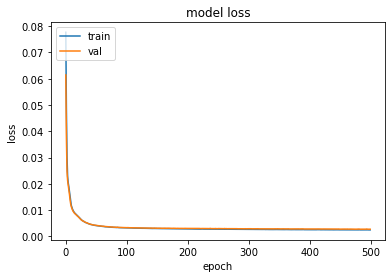

Train:  0.00248018628611014
Val:  0.0027794969290834996
Test:  0.017266909197896516
Train df(1st one) shape after AE:  (117, 23)
Test df(1st one) shape after AE:  (50, 23)
Number of set:  100
Number of set:  101
Number of set:  33
Number of set:  50
Number of set:  33
Number of set:  201
Number of set:  211
Number of set:  33


In [5]:
reset_random_seeds()
ReLu = tf.keras.initializers.HeUniform()
data_path_list = glob.glob('data/WithLabel/1*.xlsx')

list_of_origin_df=[]
for i in range(len(data_path_list)):
    xls = pd.ExcelFile(data_path_list[i])
    data_df = pd.read_excel(xls, sheet_name=0, index_col=0, header = [0,1])
    data_df.columns = data_df.columns.map(''.join)
    data_df=data_df.rename_axis('time').reset_index()
    tmp_name=list(data_df.columns)
    tmp_name[-1]='label'
    data_df.columns=tmp_name
    list_of_origin_df.append(data_df)

for string in data_path_list:
    print(string)
list_of_processed_df=list_of_origin_df.copy()
test_df_index_list=[1] # Select the index of test dataset
callback=17 # length of past records excl. current time step
# getDataSet(path_list,df_list, callback, test_df_index_list, mode, reduced_dimension)
# mode ={'PCA', 'DAE', 'POD'}, reduced_dimension = {'32', '16'}
train_sample_set, train_label_set, test_sample_set, test_label_set, conc_scaler,train_df_list,test_df_list,test_conc_list \
=getDataSet(data_path_list,list_of_processed_df, callback,test_df_index_list, 'DAE', 16)

train_sample_set shape:  (729, 18, 22)
Train len: 583, Val len: 146
x_train shape: (583, 18, 22), y_train shape:(583, 1, 6)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 18, 100)           49200     
_________________________________________________________________
dropout (Dropout)            (None, 18, 100)           0         
_________________________________________________________________
dense_4 (Dense)              (None, 18, 100)           10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 18, 100)           0         
_________________________________________________________________
dense_5 (Dense)              (None, 18, 100)           10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 18, 100)           0        

15/15 [==============================] - 0s 10ms/step - loss: 0.0153 - val_loss: 0.0117
Epoch 69/500
15/15 [==============================] - 0s 10ms/step - loss: 0.0150 - val_loss: 0.0115
Epoch 70/500
15/15 [==============================] - 0s 10ms/step - loss: 0.0148 - val_loss: 0.0112
Epoch 71/500
15/15 [==============================] - 0s 10ms/step - loss: 0.0148 - val_loss: 0.0110
Epoch 72/500
15/15 [==============================] - 0s 10ms/step - loss: 0.0146 - val_loss: 0.0108
Epoch 73/500
15/15 [==============================] - 0s 11ms/step - loss: 0.0143 - val_loss: 0.0107
Epoch 74/500
15/15 [==============================] - 0s 10ms/step - loss: 0.0141 - val_loss: 0.0105
Epoch 75/500
15/15 [==============================] - 0s 10ms/step - loss: 0.0140 - val_loss: 0.0103
Epoch 76/500
15/15 [==============================] - 0s 10ms/step - loss: 0.0137 - val_loss: 0.0101
Epoch 77/500
15/15 [==============================] - 0s 11ms/step - loss: 0.0134 - val_loss: 0.0099
Epo

15/15 [==============================] - 0s 9ms/step - loss: 0.0068 - val_loss: 0.0041
Epoch 150/500
15/15 [==============================] - 0s 9ms/step - loss: 0.0067 - val_loss: 0.0041
Epoch 151/500
15/15 [==============================] - 0s 9ms/step - loss: 0.0067 - val_loss: 0.0041
Epoch 152/500
15/15 [==============================] - 0s 9ms/step - loss: 0.0067 - val_loss: 0.0040
Epoch 153/500
15/15 [==============================] - 0s 9ms/step - loss: 0.0066 - val_loss: 0.0040
Epoch 154/500
15/15 [==============================] - 0s 8ms/step - loss: 0.0065 - val_loss: 0.0040
Epoch 155/500
15/15 [==============================] - 0s 9ms/step - loss: 0.0066 - val_loss: 0.0039
Epoch 156/500
15/15 [==============================] - 0s 10ms/step - loss: 0.0065 - val_loss: 0.0039
Epoch 157/500
15/15 [==============================] - 0s 10ms/step - loss: 0.0065 - val_loss: 0.0039
Epoch 158/500
15/15 [==============================] - 0s 10ms/step - loss: 0.0064 - val_loss: 0.0038
E

Epoch 230/500
15/15 [==============================] - 0s 9ms/step - loss: 0.0044 - val_loss: 0.0023
Epoch 231/500
15/15 [==============================] - 0s 8ms/step - loss: 0.0044 - val_loss: 0.0023
Epoch 232/500
15/15 [==============================] - 0s 9ms/step - loss: 0.0044 - val_loss: 0.0023
Epoch 233/500
15/15 [==============================] - 0s 8ms/step - loss: 0.0044 - val_loss: 0.0023
Epoch 234/500
15/15 [==============================] - 0s 8ms/step - loss: 0.0044 - val_loss: 0.0023
Epoch 235/500
15/15 [==============================] - 0s 8ms/step - loss: 0.0043 - val_loss: 0.0023
Epoch 236/500
15/15 [==============================] - 0s 8ms/step - loss: 0.0044 - val_loss: 0.0022
Epoch 237/500
15/15 [==============================] - 0s 8ms/step - loss: 0.0043 - val_loss: 0.0022
Epoch 238/500
15/15 [==============================] - 0s 9ms/step - loss: 0.0043 - val_loss: 0.0022
Epoch 239/500
15/15 [==============================] - 0s 9ms/step - loss: 0.0043 - val_los

Epoch 311/500
15/15 [==============================] - 0s 10ms/step - loss: 0.0031 - val_loss: 0.0015
Epoch 312/500
15/15 [==============================] - 0s 11ms/step - loss: 0.0032 - val_loss: 0.0015
Epoch 313/500
15/15 [==============================] - 0s 11ms/step - loss: 0.0031 - val_loss: 0.0015
Epoch 314/500
15/15 [==============================] - 0s 10ms/step - loss: 0.0031 - val_loss: 0.0015
Epoch 315/500
15/15 [==============================] - 0s 10ms/step - loss: 0.0031 - val_loss: 0.0015
Epoch 316/500
15/15 [==============================] - 0s 11ms/step - loss: 0.0031 - val_loss: 0.0015
Epoch 317/500
15/15 [==============================] - 0s 10ms/step - loss: 0.0031 - val_loss: 0.0015
Epoch 318/500
15/15 [==============================] - 0s 10ms/step - loss: 0.0030 - val_loss: 0.0015
Epoch 319/500
15/15 [==============================] - 0s 10ms/step - loss: 0.0030 - val_loss: 0.0015
Epoch 320/500
15/15 [==============================] - 0s 8ms/step - loss: 0.0030 

15/15 [==============================] - 0s 11ms/step - loss: 0.0024 - val_loss: 0.0011
Epoch 392/500
15/15 [==============================] - 0s 10ms/step - loss: 0.0024 - val_loss: 0.0011
Epoch 393/500
15/15 [==============================] - 0s 9ms/step - loss: 0.0024 - val_loss: 0.0011
Epoch 394/500
15/15 [==============================] - 0s 9ms/step - loss: 0.0023 - val_loss: 0.0011
Epoch 395/500
15/15 [==============================] - 0s 9ms/step - loss: 0.0023 - val_loss: 0.0011
Epoch 396/500
15/15 [==============================] - 0s 9ms/step - loss: 0.0024 - val_loss: 0.0011
Epoch 397/500
15/15 [==============================] - 0s 9ms/step - loss: 0.0023 - val_loss: 0.0011
Epoch 398/500
15/15 [==============================] - 0s 9ms/step - loss: 0.0023 - val_loss: 0.0011
Epoch 399/500
15/15 [==============================] - 0s 9ms/step - loss: 0.0023 - val_loss: 0.0011
Epoch 400/500
15/15 [==============================] - 0s 8ms/step - loss: 0.0023 - val_loss: 0.0010
Ep

Epoch 470/500
15/15 [==============================] - 0s 10ms/step - loss: 0.0019 - val_loss: 8.4557e-04
Epoch 471/500
15/15 [==============================] - 0s 10ms/step - loss: 0.0019 - val_loss: 8.4854e-04
Epoch 472/500
15/15 [==============================] - 0s 10ms/step - loss: 0.0019 - val_loss: 8.4807e-04
Epoch 473/500
15/15 [==============================] - 0s 11ms/step - loss: 0.0019 - val_loss: 8.3684e-04
Epoch 474/500
15/15 [==============================] - 0s 9ms/step - loss: 0.0019 - val_loss: 8.3814e-04
Epoch 475/500
15/15 [==============================] - 0s 9ms/step - loss: 0.0018 - val_loss: 8.3587e-04
Epoch 476/500
15/15 [==============================] - 0s 10ms/step - loss: 0.0019 - val_loss: 8.2624e-04
Epoch 477/500
15/15 [==============================] - 0s 9ms/step - loss: 0.0019 - val_loss: 8.3368e-04
Epoch 478/500
15/15 [==============================] - 0s 9ms/step - loss: 0.0018 - val_loss: 8.2711e-04
Epoch 479/500
15/15 [=============================

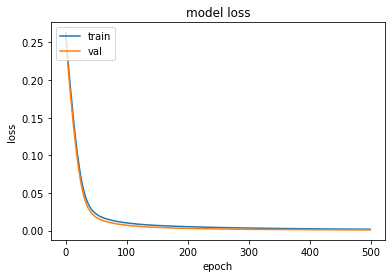

Evaluate on test data
MSE: 0.07168900442909397
Evaluate on validation
MSE: 0.06500564687033011
MSE:  0.07168900442909397


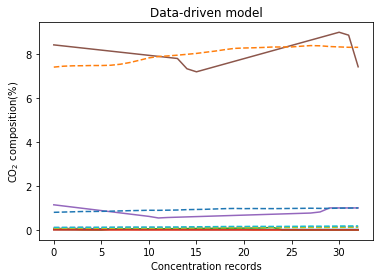

In [6]:
trainSequenceLSTM('train', train_sample_set, train_label_set, test_sample_set, test_label_set)
model = keras.models.load_model('LSTM_MSE.h5')
predict_set=model.predict(test_sample_set)
plt.plot(conc_scaler.inverse_transform(test_label_set.reshape(test_label_set.shape[0],6)))
plt.plot(conc_scaler.inverse_transform(np.mean(predict_set,axis=1)),linestyle='dashed')
plt.title('Data-driven model')
plt.xlabel('Concentration records')
plt.ylabel('CO$_2$ composition(%)')
#plt.yscale('log')
#plt.ylim(-0, 0.15)
#plt.savefig('Data-driven.png',dpi=1000)
print('MSE: ', mean_squared_error(conc_scaler.inverse_transform(test_label_set.reshape(test_label_set.shape[0],6)),
                                  conc_scaler.inverse_transform(np.mean(predict_set,axis=1))))

# Model fusion

kinetic_model\140206_1.csv  in test


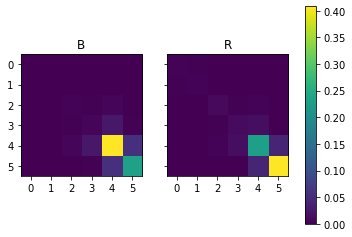

In [7]:
dynamic_path_list = glob.glob('kinetic_model/1*.csv')
def VAR_3D(xb,Y,H,B,R): #booleen=0 garde la trace
    # xb: priori, Y: observation, H: obs. matrix, B: priori estimate uncertainty
    # R: Measurement uncertainty
    dim_x = xb.size
    #dim_y = Y.size
    Y.shape = (Y.size,1)
    xb1=np.copy(xb)
    xb1.shape=(xb1.size,1)
    K=np.dot(B,np.dot(np.transpose(H),np.linalg.pinv(np.dot(H,np.dot(B,np.transpose(H)))+R))) #matrice de gain
    
    A=np.dot(np.dot((np.eye(dim_x)-np.dot(K,H)),B),np.transpose((np.eye(dim_x)-np.dot(K,H))))+np.dot(np.dot(K,R),np.transpose(K))
    vect=np.dot(H,xb1)
    xa=np.copy(xb1+np.dot(K,(Y-vect)))
    return xa.ravel(),A

test_name_list=[]
for i in range(len(test_df_index_list)):
    test_name_list.append(os.path.splitext(os.path.basename(data_path_list[test_df_index_list[i]]))[0])
    
dynamic_df_list=[]
dynamic_train_list=[]
dynamic_test_list=[]
for path in dynamic_path_list:
    dynamic_df_list.append(pd.read_csv(path, header=None))
    if os.path.splitext(os.path.basename(path))[0] not in test_name_list:
        dynamic_train_list.append(pd.read_csv(path, header=None))
    else:
        print(path, ' in test')
        dynamic_test_list.append(pd.read_csv(path, header=None))

for i in range(len(dynamic_train_list)):
    if (i==0):
        train_full_values=dynamic_train_list[i].values[callback:,:]
    else:
        train_full_values=np.concatenate((train_full_values, dynamic_train_list[i].values[callback:,:]), axis=0)
B=np.cov((train_full_values*100-conc_scaler.inverse_transform(train_label_set.reshape(train_label_set.shape[0],6))).T)
B=covLoc(B,2)
np.save('B.npy',B)

for i in range(len(dynamic_test_list)):
    if (i==0):
        test_full_values=dynamic_test_list[i].values[callback:,:]
    else:
        test_full_values=np.concatenate((test_full_values, dynamic_test_list[i].values[callback:,:]), axis=0)

R=np.load('R.npy')
B=np.load('B.npy')
fig,axs=plt.subplots(nrows=1, ncols=2,sharey=True)
axs[0].set_xticks(np.arange(0, 6, step=1))
axs[1].set_xticks(np.arange(0, 6, step=1))
#im1=axs[0].imshow(B,norm=LogNorm())
#im2=axs[1].imshow(R,norm=LogNorm())
im1=axs[0].imshow(B)
axs[0].set_title('B')
im2=axs[1].imshow(R)
axs[1].set_title('R')
cb=fig.colorbar(im1,ax=axs.ravel().tolist())
#plt.savefig('cov.png',dpi=1000)
plt.show()

H=np.eye(6)
conc_set=test_full_values.copy()
for i in range(conc_set.shape[0]):
    conc_set[i],_ = VAR_3D(test_full_values[i]*100,conc_scaler.inverse_transform(np.mean(predict_set,axis=1))[i],H,B,R)

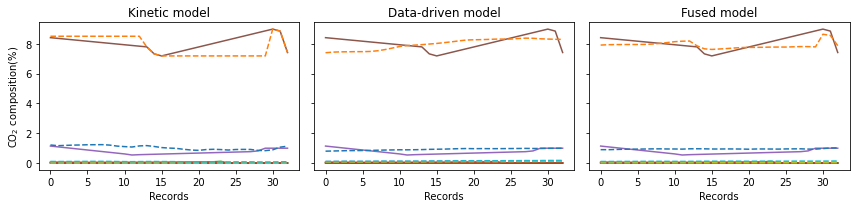

In [8]:
fig, axs = plt.subplots(1,3, sharey=True, figsize=(12,3))
#plt.ylim(-0, 4.5)
axs[0].plot(conc_scaler.inverse_transform(test_label_set.reshape(test_label_set.shape[0],6)))
axs[0].plot(test_full_values*100,linestyle='dashed')
axs[0].set_title('Kinetic model')
axs[0].set_ylabel('CO$_2$ composition(%)')
axs[0].set_xlabel('Records')
axs[1].plot(conc_scaler.inverse_transform(test_label_set.reshape(test_label_set.shape[0],6)))
axs[1].plot(conc_scaler.inverse_transform(np.mean(predict_set,axis=1)),linestyle='dashed')
axs[1].set_title('Data-driven model')
axs[1].set_xlabel('Records')
axs[2].plot(conc_scaler.inverse_transform(test_label_set.reshape(test_label_set.shape[0],6)))
axs[2].plot(conc_set,linestyle='dashed')
axs[2].set_title('Fused model')
axs[2].set_xlabel('Records')
plt.tight_layout()
#plt.savefig('compare_set1.png',dpi=1000)